# **Statistics Lab 52568 - Lab 5**

Menachem Sokolik 314696972

Idan Keipour 315355537

Maria Mordvova 345232821


In [ ]:
import numpy as np  # a module for working with numerical array 
import pandas as pd  # a module for working with data-frames
from matplotlib import pyplot as plt
import random
import statsmodels.api as sm
from sklearn.decomposition import PCA
from matplotlib.pyplot import figure 
from functools import partialmethod 
from sklearn.preprocessing import normalize
import io


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


First, we need to mount our local drive to the colab network

In [ ]:
# Add a check if we run in google colab or locally in jupyter notebook
run_in_colab = False
if 'google.colab' in str(get_ipython()):
    run_in_colab = True
    print('Running on CoLab')
else:
    print('Running locally on Jupyter')

# Mount drive in google colab
if run_in_colab:
    from google.colab import drive
    drive.mount('/content/drive')
else:  # Set local path 
    data_path = "C:/Users/menac/OneDrive/Desktop/52568 STATISTICS LAB/LAB2"

Running on CoLab
Mounted at /content/drive


In [ ]:
# Loading elections 2021 elections data - ballot:
if run_in_colab:
    from google.colab import files
    uploaded = files.upload()

Saving eshkol_hevrati_calcali.csv to eshkol_hevrati_calcali.csv
Saving eshkol_hevrati_calcali.xlsx to eshkol_hevrati_calcali.xlsx
Saving HevratiCalcaliYeshuvim.csv to HevratiCalcaliYeshuvim.csv
Saving votes per ballot 2021.csv to votes per ballot 2021.csv
Saving votes per city 2021.csv to votes per city 2021.csv


In [ ]:
df_2021_raw = pd.read_csv(io.BytesIO(uploaded['votes per city 2021.csv']),  encoding = 'iso-8859-8',index_col='שם ישוב') # loading cities data
df_2021_raw = df_2021_raw[df_2021_raw.index != 'מעטפות חיצוניות'] # dropping out מעטפות חיצוניות
df_2021 = df_2021_raw.drop('סמל ועדה', axis=1) # new column added in Sep 2019
df_2021 = df_2021[df_2021.columns[5:-1]] # removing "metadata" columns

parties_dict_2021 ={'אמת' : "עבודה", 'מרצ' : "מרצ",  'ג' : "יהדות התורה", 'עם'  : "רעם",  'ת'  : "תקוה חדשה", 'ודעם'  : "הרשימה המשותפת", 'ב'  : "ימינה", 'ט'  : "הציונות הדתית",
 'ל'  : "ישראל ביתנו", 'מחל'  : "הליכוד",  'פה'  : "יש עתיד", 'כן'  : "כחול לבן", 'שס'  : "שס"}
df_2021.rename(columns=parties_dict_2021, inplace=True)

In [ ]:
df_2021_ballots_raw = pd.read_csv(io.BytesIO(uploaded['votes per ballot 2021.csv']),  encoding = 'iso-8859-8',index_col='שם ישוב') # loading cities data
df_2021_ballots_raw = df_2021_raw[df_2021_raw.index != 'מעטפות חיצוניות'] # dropping out מעטפות חיצוניות

We use only the parties which their voting **percentage** 
in a given city is above a % threshold, and we remove the results of 'Maatafot hitzoniot':

In [ ]:
# Compute votes share only for parties above a certain threshold 
def parties_votes_percents(df, thresh):
    par = df.sum().div(df.sum().sum()).sort_values(ascending=False)
    return par[par > thresh]

total_votes = parties_votes_percents(df_2021, 0.035)  # total votes for each party
names = total_votes.keys() # 13 parties

# Data with only the 13 relevant parties:
df_2021 = df_2021[names]


**Question 1. - Calculation the new fix parameter using linear regression OLS.**

In [ ]:
def linear_regression_lab_5(df, n_i):
  bzb= n_i 
  bollots = pd.get_dummies(df.index) * df.sum(axis=1)
  matrix = pd.concat([df.reset_index(drop=True), bollots.reset_index(drop=True)], axis=1)
  model = sm.OLS(bzb, matrix).fit()

  n_ij = pd.DataFrame(np.add(df.mul(model.params[:13], axis =1),df.mul(model.params[13:], axis =0))) # n_ij*alpha_i + n_ij*beta_i
  q_hat_lab_5 = n_ij.sum().div(n_ij.sum().sum())

  return q_hat_lab_5

***Question 2. -***

In [ ]:
def linear_regression(df, n_i):
    p = df.sum().div(df.sum().sum())
    bzb = n_i 
    
    model = sm.OLS(bzb, df).fit()
    
    q_hat = p*model.params
    q_hat = q_hat / (q_hat.sum())
    return p, q_hat, model.params

In [ ]:
def sim_data(N,V):
  new_df = pd.DataFrame(np.random.binomial(N,V))
  new_df.index = df_2021.index
  return new_df

In [ ]:
# Nij~ :
N_tilde = np.array(df_2021.mul(df_2021_raw['בזב'].sum()).div(df_2021_raw['כשרים'].sum()),dtype='int32')
n_i = N_tilde.sum(axis=1)

# 3 types of Vi 
v = df_2021_raw['כשרים'].div(df_2021_raw['בזב'])
u = [0.6,0.65,0.75,0.5,0.4,0.35,0.8,0.55,0.45,0.25,0.3,0.7,0.2]  # arbitrary ordering
u_random = random.sample(u, len(u))

dim = df_2021.shape
# converting them to the desired shape:
V_v = np.tile(np.array([v]).transpose(), (1, len(names)))
V_u = np.tile(np.array(u), (dim[0],1))
V_u_random = np.tile(np.array(u_random), (dim[0],1))

A function that calculates the p and the q_hat (after fixing data to 100% votes with Vi= kosher(i)/bzb(i))

In [ ]:
def fixing_data(df, fix_param):
  p = parties_votes_percents(df, 0) 
  q_hat = parties_votes_percents(df.div(fix_param, axis = "rows"), 0)
  return q_hat

50-simulations function:

In [ ]:
def simulations(iters, N, V):
  p_mat = np.zeros([iters, len(names)])
  q_hat_mat = np.zeros([iters, len(names)]) 
  q_hat = np.zeros([iters, len(names)])
  q_hat_lab_5 = np.zeros([iters, len(names)])

  # in every simulation we calculate p and q_hat (after fixing the data)
  for i in range(0,iters):
    new_df = sim_data(N,V)
    q_hat[i,] = fixing_data(new_df, new_df.sum(axis=1)/ N.sum(axis=1))
    p_mat[i,], q_hat_mat[i,] = linear_regression(new_df, n_i)[0:2]
    q_hat_lab_5[i,]= linear_regression_lab_5(new_df, n_i)

  return p_mat, q_hat, q_hat_mat, q_hat_lab_5

In [ ]:
iters = 50 # number of simulations
q_real = N_tilde.sum(axis=0)/(N_tilde.sum())

sim_v = simulations( iters, N_tilde, V_v)
mean_p_v = sim_v[0].mean(axis=0)
mean_q_v = sim_v[1].mean(axis=0)
mean_q_v_lab_4 = sim_v[2].mean(axis=0)
mean_q_v_lab_5 = sim_v[3].mean(axis=0)

var_q_v = sim_v[1].var(axis=0)
var_q_v_lab_4 = sim_v[2].var(axis=0)
var_q_v_lab_5 = sim_v[3].var(axis=0)


sim_u = simulations(iters, N_tilde, V_u)
mean_p_u = sim_u[0].mean(axis=0) 
mean_q_u = sim_u[1].mean(axis=0) 
mean_q_u_lab_4 = sim_u[2].mean(axis=0)
mean_q_u_lab_5 = sim_u[3].mean(axis=0)

var_q_u = sim_u[1].var(axis=0) 
var_q_u_lab_4 = sim_u[2].var(axis=0)
var_q_u_lab_5 = sim_u[3].var(axis=0)


sim_u_random = simulations(iters, N_tilde, V_u_random)
mean_p_u_random = sim_u_random[0].mean(axis=0)
mean_q_u_random = sim_u_random[1].mean(axis=0)
mean_q_u_random_lab_4 = sim_u_random[2].mean(axis=0)
mean_q_u_random_lab_5 = sim_u_random[3].mean(axis=0)

var_q_u_random = sim_u_random[1].var(axis=0)
var_q_u_random_lab_4 = sim_u_random[2].var(axis=0)
var_q_u_random_lab_5 = sim_u_random[3].var(axis=0)

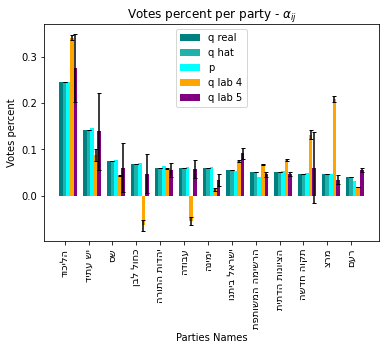

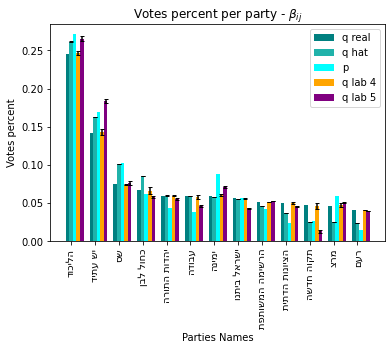

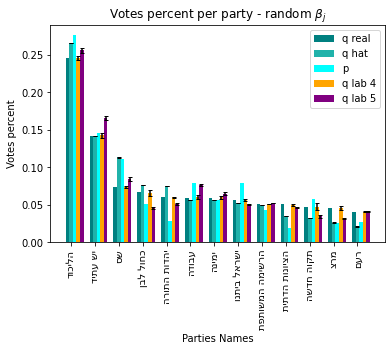

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb8810b69d0>)

In [ ]:
# Bar plot for a party, only showing values above a certain threshold after fixing:
def party_bar_fix(q_real, q_hat, p, q_lab_4, q_lab_5, error, error_lab_4, error_lab_5, sim):
    width = 0.15  # set column width 
    n = len(total_votes)

    rev_names = [name[::-1] for name in list(names)]
    fig, ax = plt.subplots()  # plt.subplots()

    q_real_bar = ax.bar(np.arange(n) - width, list(q_real), width, color='teal')
    q_hat_bar = ax.bar(np.arange(n), q_hat, width, color='lightseagreen', yerr=error, capsize=2)
    p_bar = ax.bar(np.arange(n) + width, p, width, color='aqua')
    q_lab_4_bar = ax.bar(np.arange(n) + 2*width, q_lab_4, width, color='orange', yerr=error_lab_4, capsize=2)
    q_lab_5_bar =  ax.bar(np.arange(n) + 3*width, q_lab_5, width, color='purple', yerr=error_lab_5, capsize=2)

    ax.set_ylabel('Votes percent')
    ax.set_xlabel('Parties Names')
    ax.set_title('Votes percent per party - ' + sim)
    ax.set_xticks(np.arange(n))
    ax.set_xticklabels(rev_names, rotation=90)
    ax.legend((q_real_bar, q_hat_bar, p_bar, q_lab_4_bar,q_lab_5_bar), ('q real', 'q hat', 'p', 'q lab 4', 'q lab 5'))
    plt.show()

    return fig, ax

party_bar_fix(q_real, mean_q_v, mean_p_v, mean_q_v_lab_4, mean_q_v_lab_5, np.sqrt(var_q_v), np.sqrt(var_q_v_lab_4), np.sqrt(var_q_v_lab_5), r'$\alpha_{ij}$')
party_bar_fix(q_real, mean_q_u, mean_p_u, mean_q_u_lab_4, mean_q_u_lab_5, np.sqrt(var_q_u), np.sqrt(var_q_u_lab_4), np.sqrt(var_q_u_lab_5), r'$\beta_{ij}$')
party_bar_fix(q_real, mean_q_u_random, mean_p_u_random, mean_q_u_random_lab_4, mean_q_u_random_lab_5, np.sqrt(var_q_u_random), np.sqrt(var_q_u_random_lab_4), np.sqrt(var_q_u_random_lab_5), r'random $\beta_j$')


From analyzing the barblots we can clearly see that q_hat is best estimator for the first type of the simulation, while the q_lab4 and q_lab5 do not really reflect the reality, besides q_lab4 has a great varince, that does not suspected in other estimators. For the second case of simulation, we cant clearly say that one of the estimators way better than others. For the third simulation we can observe that q_lab4 is the best estimator.



**Question 3. Parties PCA**

In [ ]:
if   run_in_colab:
  df_2021_ballots_raw = pd.read_csv(io.BytesIO(uploaded['votes per ballot 2021.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
else:
  df_2021_ballots_raw = pd.read_csv(data_path + 'votes per ballot 2021.csv',  encoding = 'iso-8859-8', index_col='שם ישוב')  # need to read locally

df_2021_ballots = df_2021_ballots_raw.drop('סמל ועדה', axis=1) # new column added in Sep 2019
df_2021_ballots = df_2021_ballots.drop("מעטפות חיצוניות")

if  run_in_colab:
    df_socio= pd.read_excel(io.BytesIO(uploaded['eshkol_hevrati_calcali.xlsx']), index_col='name')
else:
    df_socio= pd.read_excel('eshkol_hevrati_calcali.xlsx', index_col='name')

df_2021_raw = pd.read_csv(io.BytesIO(uploaded['votes per city 2021.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
df_2021 = df_2021_raw.drop('סמל ועדה', axis=1) # new column added in Sep 2019
df_2021 = df_2021[df_2021.columns[5:-1]] # removing "metadata" columns

In [ ]:
total_votes = parties_votes_percents(df_2021, 0.0375)  # total votes for each party
names_3 = total_votes.keys() # 13 parties

# Data with only the 13 relevant parties:
df_2021 = df_2021[names_3]

**Question 3-a.**


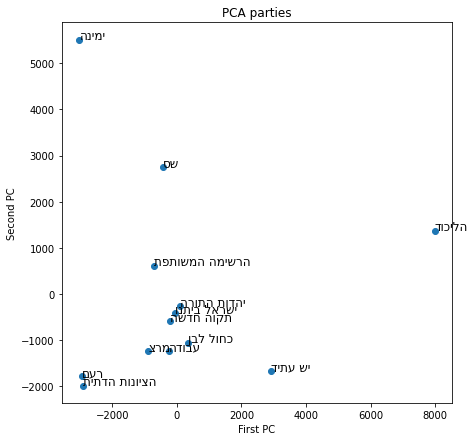

In [ ]:
df_2021_ballots = df_2021_ballots[names_3]
pca = PCA(n_components =2)
res = pca.fit_transform(df_2021_ballots.T)
fig, ax = plt.subplots(figsize=(7,7))
a = res[:,0]
b = res[:,1]
ax.scatter(a,b)
ax.set_title("PCA parties")
ax.set_xlabel("First PC")
ax.set_ylabel("Second PC")
for i in range(13):
    a_i = res[i,0]
    b_i = res[i,1]
    ax.annotate(names[i][::-1] , (a_i,b_i), fontsize=12)
plt.show()

First PCA: decreasing dim according to the voting distribution: Parties that are situated around 0, its the parties that did not get trough the passing percentage. The more votes the party got, then it is situated more far away from 0. 

Second PCA: decreasing dim based on the votes in precise location. So, parties which on the top (Yamina) received votes from the voters in different location, while parties which are situated downside, for e.g. "Ram" has received its votes from the one location.



**Question 3-b.**

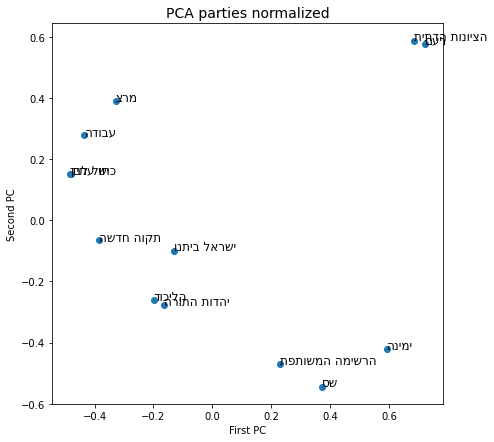

In [ ]:
from sklearn import preprocessing
df_2021_ballots_normalized = preprocessing.normalize(df_2021_ballots , axis=0)

pca = PCA(n_components =2)
res = pca.fit_transform(df_2021_ballots_normalized.T)
fig, ax = plt.subplots(figsize=(7,7))
a = res[:,0]
b = res[:,1]
ax.scatter(a , b)
ax.set_xlabel("First PC")
ax.set_ylabel("Second PC")
ax.set_title("PCA parties normalized" , fontsize=14)
for i in range(13):
    a_i = res[i,0]
    b_i = res[i,1]
    ax.annotate(names[i][::-1] , (a_i,b_i), fontsize=12)
plt.show()

After normalization we can notice that not only the values of the components have changed, but also the form of the dispersion became more broad.  It might be caused due to the change of PC components or it is possible that the meaning of the components has not really changed but that the weight of each party on each component has changed as a result of normalization.

**Question 4.**

**Question 4-a.**

In [ ]:
df_2021_raw = df_2021_raw[df_2021_raw.columns[0:-1]]
#Joining the dataframes
merged_data = df_2021_raw.join(df_socio.set_index('set_code'), on='סמל ישוב') #joining the dataframes by the set code column
merged_data = merged_data.dropna()

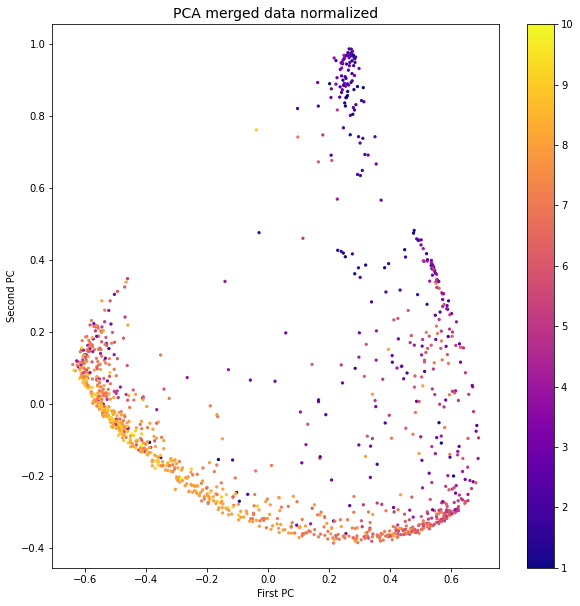

In [ ]:
level = merged_data['eco_level']
merged_data_normalized = preprocessing.normalize(merged_data[names_3].T , axis=0)
pca = PCA(n_components=2)
res = pca.fit_transform(merged_data_normalized.T)
fig, ax = plt.subplots(figsize=(10,10))
a = res[:,0]
b = res[:,1]
plt.colorbar(ax.scatter(a, b, c = level, s = 5, cmap='plasma'))
ax.set_xlabel("First PC")
ax.set_ylabel("Second PC")
ax.set_title("PCA merged data normalized" , fontsize=14)
plt.show()

It is can be clearly seen that polling stations with a relatively low economic rate are concentrated on the right side of the X-axis (dark blue and purple), while parties with a relatively high economic rating are concentrated mainly on the left side of the axis (light yellow and green).

Therefore the horizontal x-axis means socioeconomic status so that the higher the value the lower the socioeconomic status, and the vertical y-axis  represents the right or left affiliation of the same ballot box where the voting took place. The higher the value - the more centered and left, and the value the lower, then affiliation is the more right.

**Question 4-b.**

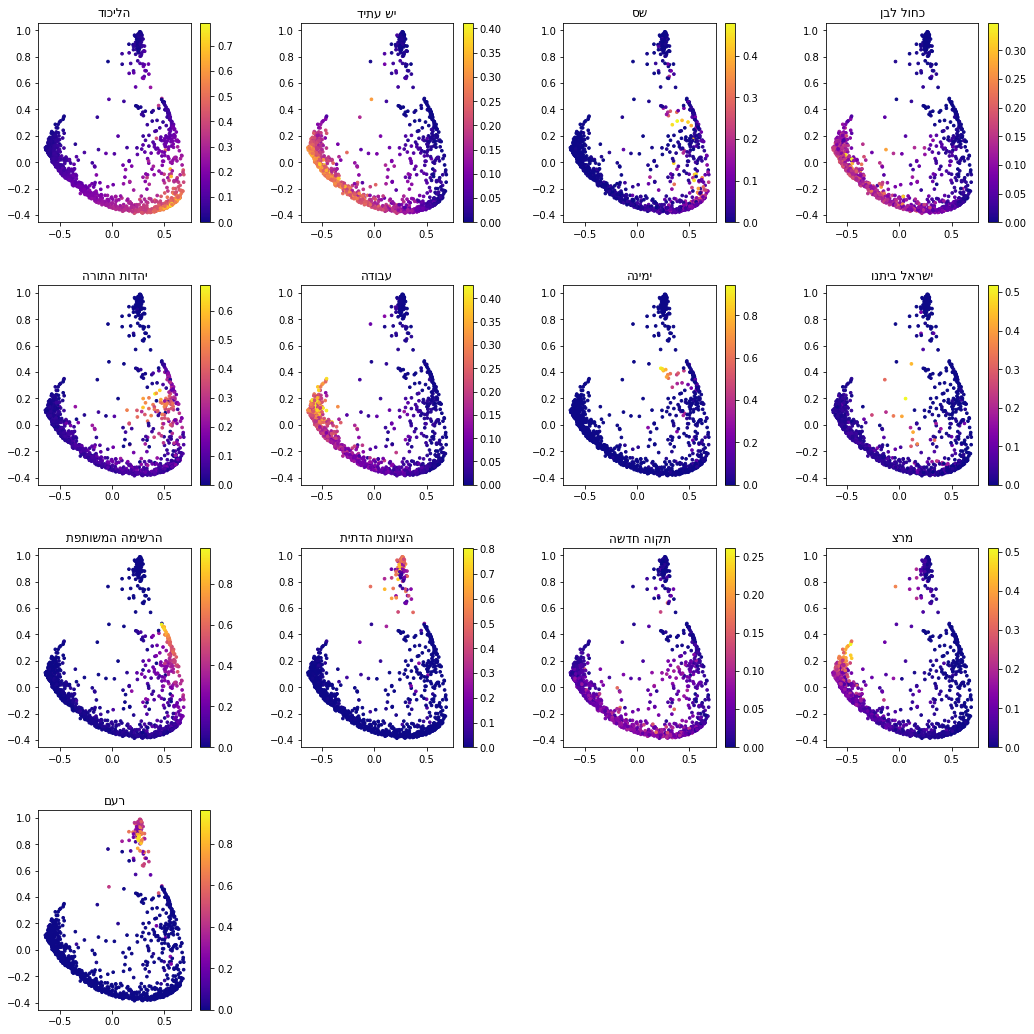

In [ ]:
rev_names = [name[::-1] for name in list(names)]
level = pd.DataFrame()
for i in range(13):
  level.loc[::,names_3[i]] = merged_data[names_3[i]].div(merged_data['כשרים'])
figure(figsize=(15,15))
for i in range(13):
  party_i = rev_names[i]
  plt.subplot(4,4,i+1)
  ax.set_xlabel("First PC")
  ax.set_ylabel("Second PC")
  plt.title(party_i,fontsize=12)
  plt.colorbar(plt.scatter(res[:,0], res[:,1], marker = 'o',c = level.iloc[:,i] ,s=7, cmap='plasma'))
  plt.tight_layout(pad=3)

As we claimed in the previous section the meaning of the horizontal *x-axis is socio-economic status* and vertical *y-axis  represents a right-wing or left-wing affiliation* of the same ballot box where the voting took place.


We will proceed the comparison between "RAM" and "Kahol Lavan". As it can be clearly seen that most people who vote from "RAM" come from low levels of socio-economic rate and and left believes. On the opposite, voters for "Kahol Lavan" are from high socio-economic level and share more right believes. 


As noticed, the conclusion of this lab matches with our conclution from the last task of Lab4. 

